## Semantic Data Filter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

EMBEDDED_CATEGORIES_FILE = 'data/embedded_categories.npy'

embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [2]:
df_business = pd.read_csv('data/yelp_academic_dataset_business.csv')
df_business = df_business.dropna(subset=['categories'])

In [3]:
df_business.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",NaN
4,4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': ""{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [4]:
restaurants = set(pd.read_csv('data/Top250.csv')['Segment_Category'])
restaurants_keywords = restaurant_text = " ".join(restaurants)

*Semantic Info to Match:*

In [11]:
context = restaurants_keywords
print("CONTEXT TO MATCH:")
print(context)
embedded_context = embedder([context]).numpy()

CONTEXT TO MATCH:
Quick Service & Coffee Cafe Quick Service & Bakery Cafe Family Casual Fast Casual & Sandwich Coffee Cafe Quick Service & Pizza Quick Service & Seafood Quick Service & Burger Quick Service & Snack Quick Service & Chicken Fast Casual & Burger Fast Casual & Pizza Sports Bar Ethnic Quick Service & Frozen Desserts Seafood Quick Service & Family Casual Quick Service & Mexican Asian Asian/Noodle Steak Fine Dining & Steak Burger Bakery Cafe Casual Dining & Varied Menu Quick Service & Beverage Sandwich Family Style Casual Dining & Italian/Pizza Healthy Frozen Desserts Fast Casual & Asian/Noodle Casual Dining & Sports Bar Fast Casual & Chicken Varied Menu Casual Dining & Steak Quick Service & Sandwich Italian/Pizza Pizza Fast Casual & Bakery Cafe Fast Casual & Mexican Snack Casual Dining & Seafood Casual Dining & Asian Family Dining & Family Style Mexican BBQ Chicken


In [18]:
try:
    with open(EMBEDDED_CATEGORIES_FILE, 'rb') as f:
        embedded_categories = np.load(EMBEDDED_CATEGORIES_FILE, allow_pickle=True)
    print('EMBEDDINGS LOADED')

except IOError as e:
    print('ARRAY NOT FOUND. EMBEDDING:')
    categories = list(df_business['categories'])
    embedded_categories = embedder(categories).numpy()
    np.save(EMBEDDED_CATEGORIES_FILE, embedded_categories)
    print('EMBEDDINGS SAVED')

EMBEDDINGS LOADED


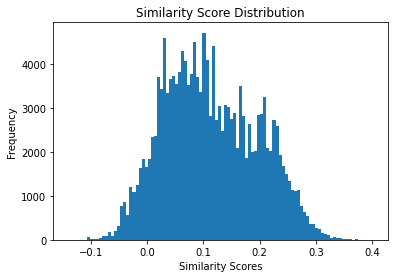

In [22]:
similarity_dist = embedded_categories @ embedded_context.T
plt.title('Similarity Score Distribution')
plt.hist(similarity_dist, bins=100)
plt.xlabel('Similarity Scores')
plt.ylabel('Frequency')
plt.show()

In [20]:
split_dex = np.where(similarity_dist >= 0.14)[0]
df_filtered = df_business.iloc[split_dex, :]
df_filtered.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
5,5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': ""u'none'"", ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
10,10,rYs_1pNB_RMtn5WQh55QDA,Chautauqua General Store,100 Clematis Dr,Boulder,CO,80302,39.998449,-105.281006,3.5,5,1,"{'BikeParking': 'True', 'RestaurantsTakeOut': ...","Food, Shopping, Convenience Stores, Souvenir S...","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ..."
12,12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
